In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import copy
import torch
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

In [3]:
## Directory containing cloned repos like GCaMP_ROI_classifier and basic_neural_processing_modules
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

dir_analysisFiles = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0').resolve()

## Directory to save outputs from this notebook like iscell
dir_save = dir_analysisFiles


## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=norm.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=norm' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.
fileName_classifier = 'logreg_model_0.01.pkl' # path to logististic classifier pickle file in dir_classifiers

In [4]:
## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_classifiers = dir_GRC_EndUser / 'classifier-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py
path_classifier = dir_classifiers / fileName_classifier

path_statFile = dir_s2p / 'stat.npy'

In [5]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))

%load_ext autoreload
%autoreload 2
import util
from basic_neural_processing_modules import *

In [6]:
## Device to use for NN model
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [7]:
## TODO: Troubleshoot the runtime on this
# def drop_nan_imgs(rois):
#     ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(rois), dim=1), dim=1))[0]
#     return rois[ROIs_without_NaNs]

def dataloader_to_latents(dataloader, model, DEVICE='cpu'):
    def subset_to_latents(data):
        return model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu()
    return torch.cat([subset_to_latents(data) for data in tqdm(dataloader)], dim=0)

def load_classifier_model(classifier_name):
    with open(classifier_name, 'rb') as classifier_model_file:
        classifier = pickle.load(classifier_model_file)
    return classifier

4870 ROIs loaded.


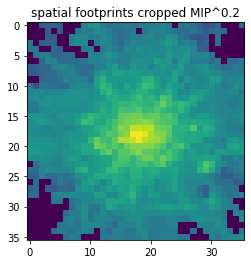

In [8]:
spatial_footprints = torch.as_tensor(
    util.statFile_to_spatialFootprints(path_statFile, out_height_width=[36,36], max_footprint_width=455)
)

# spatial_footprints = drop_nan_imgs(spatial_footprints)
print(spatial_footprints.shape[0], 'ROIs loaded.')


In [9]:
# Instantiate Model
import importlib
# model_file = importlib.util.spec_from_file_location('path_NN_py')
model_file = importlib.import_module(fileName_NN_py)
model = model_file.get_model(path_NN_pth)
model.eval();

In [12]:
# Create Data Sets / Data Loaders
dataset, dataloader = model_file.get_dataset_dataloader(spatial_footprints, batch_size=64, device=DEVICE) ## TODO: Troubleshoot the runtime on this

In [13]:
model.to(DEVICE);

In [14]:
# Get Model Latents
latents = dataloader_to_latents(dataloader, model, DEVICE=DEVICE).numpy()

  0%|          | 0/77 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
# Load Logistic Model
classifier_model = load_classifier_model(path_classifier)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
# Predict ROIs — Save to File
proba = classifier_model.predict_proba(latents)
preds = np.argmax(proba, axis=-1)
uncertainty = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=None).detach().cpu().numpy()
    
params = classifier_model.get_params()

In [17]:
ROI_classifier_outputs = {
    'latents': latents,
    'proba': proba,
    'preds': preds,
    'uncertainty': uncertainty,
    'LR_params': params
}

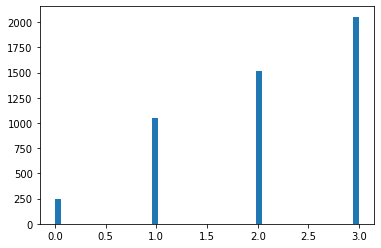

In [18]:
%matplotlib inline
plt.figure()
plt.hist(preds, 50);

In [19]:
preds_toUse = [0,1]

iscell_NN = np.isin(preds, preds_toUse)
iscell_NN_idx = np.where(iscell_NN)[0]

print(f'number of included ROIs: {len(iscell_NN_idx)}')

number of included ROIs: 1296


including


<IPython.core.display.Javascript object>


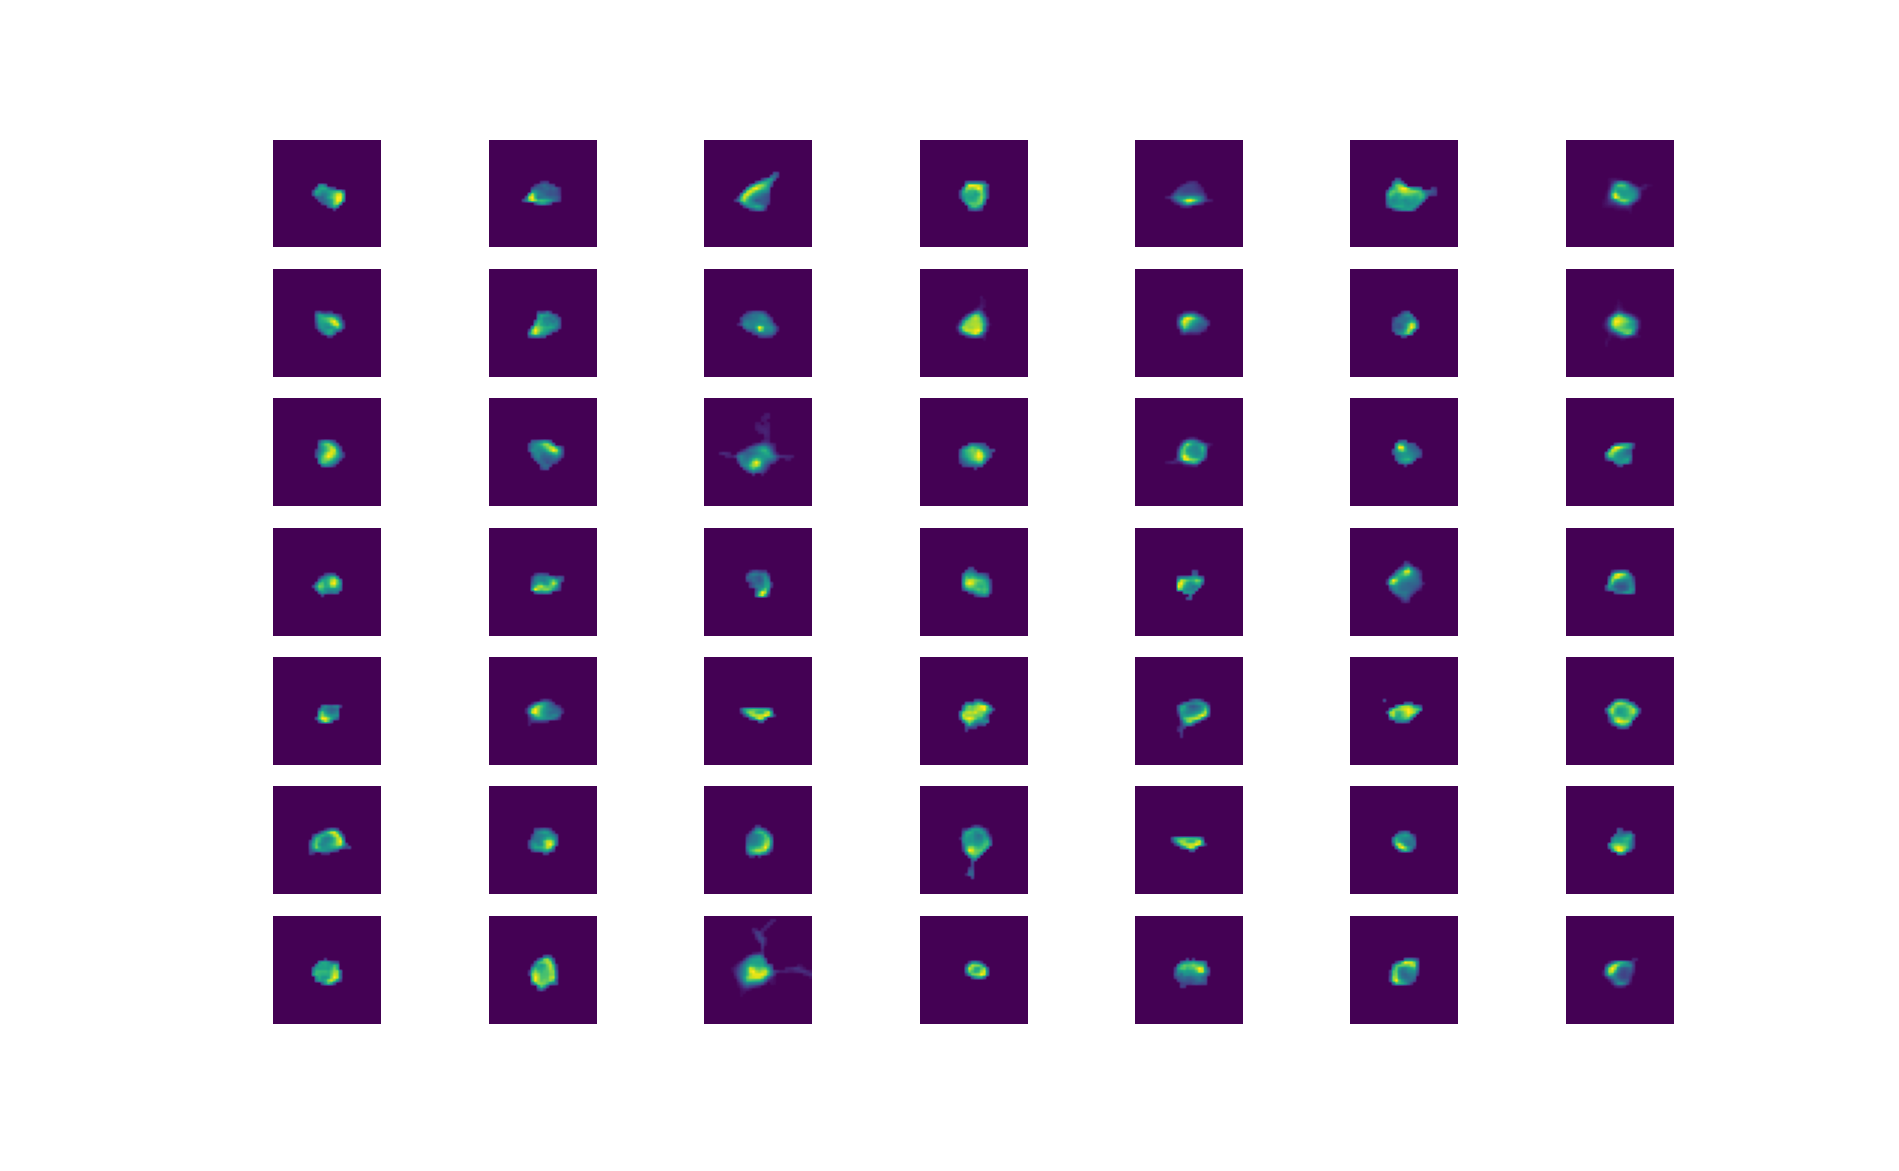

excluding


<IPython.core.display.Javascript object>


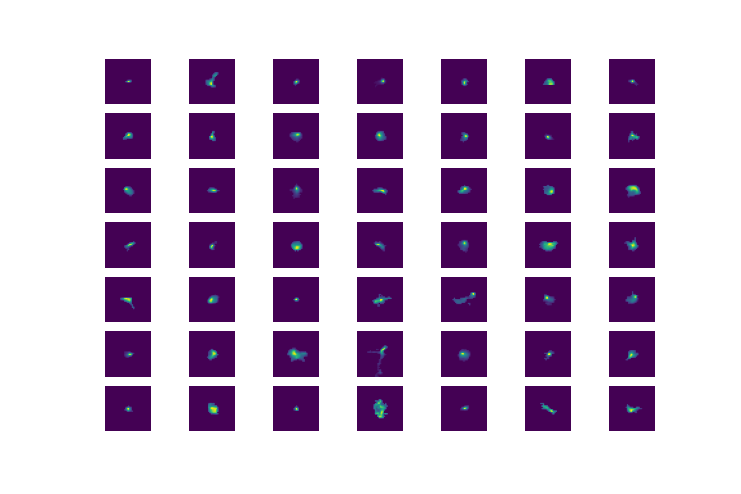

In [20]:
%matplotlib notebook

grid_shape = (7,7)

print('including')
plotting_helpers.plot_image_grid(
    spatial_footprints[np.random.choice(iscell_NN_idx, np.prod(grid_shape))],
    grid_shape=grid_shape, 
    show_axis='off', 
);

print('excluding')
plotting_helpers.plot_image_grid(
    spatial_footprints[np.random.choice(np.where(~iscell_NN)[0], np.prod(grid_shape))],
    grid_shape=grid_shape, 
    show_axis='off', 
);

In [21]:
np.save(
    file=dir_save / 'iscell_NN.npy',
    arr=iscell_NN
)

pickle_helpers.simple_save(
    obj=ROI_classifier_outputs,
    filename=dir_save / 'ROI_classifier_outputs.pkl'
)